In [57]:
#load libraries
import pandas as pd
import seaborn as sns
import numpy as np

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import RobustScaler
import shap

In [3]:
#read data
airbnb = pd.read_csv('data/AB_NYC_2019.csv')
airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
#Drop duplicates
airbnb.drop_duplicates(inplace=True)

In [5]:
# Check NA
airbnb.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [6]:
#Drop unused columns
airbnb.drop(['name','id','host_name','last_review','host_id'], axis=1, inplace=True)

In [7]:
# Fill NA
airbnb.fillna({'reviews_per_month':0}, inplace=True)

In [8]:
#check NA
airbnb.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [9]:
airbnb.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


<AxesSubplot:xlabel='price'>

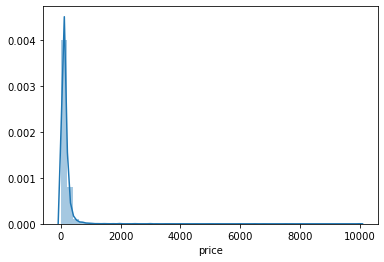

In [10]:
sns.distplot(airbnb.price)

In [37]:
# Data modeling
y = airbnb.price              
X = airbnb.drop(['price'], axis=1)

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [55]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39116 entries, 5374 to 2732
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             39116 non-null  object 
 1   neighbourhood                   39116 non-null  object 
 2   latitude                        39116 non-null  float64
 3   longitude                       39116 non-null  float64
 4   room_type                       39116 non-null  object 
 5   minimum_nights                  39116 non-null  int64  
 6   number_of_reviews               39116 non-null  int64  
 7   reviews_per_month               39116 non-null  float64
 8   calculated_host_listings_count  39116 non-null  int64  
 9   availability_365                39116 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 3.3+ MB


In [60]:
objc_type = [cnm for cnm in X_train.columns if X_train[cnm].nunique()<10 and X_train[cnm].dtype == 'object']
numeric_type = [cnm for cnm in X_train.columns if X_train[cnm].dtype == 'float64' or X_train[cnm].dtype == 'int64']
cls_training = objc_type + numeric_type

In [61]:
X_train2 = X_train[cls_training].copy()
X_valid2 = X_valid[cls_training].copy()

In [63]:
X_train2 = pd.get_dummies(X_train2)
X_valid2 = pd.get_dummies(X_valid2)

In [64]:
my_model = XGBRegressor()
my_model.fit(X_train2, y_train)

[13:16:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [51]:
def calculate_mape(actual, pred):
    Error = np.sum(np.abs(np.subtract(actual,pred)))
    Average = np.sum(y_valid)
    MAPE = Error/Average
    return MAPE

In [83]:
predictions = my_model.predict(X_valid2)
print("MAE: " + str(np.round(mean_absolute_error(predictions, y_valid)))+
      ", RMSE: "+str(np.round(np.sqrt(mean_squared_error(predictions, y_valid)),3))+
      ", MAPE: "+str(np.round(calculate_mape(y_valid, predictions),3)))

MAE: 68.0, RMSE: 220.223, MAPE: 0.442


In [68]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_train2, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid2, y_valid)], 
             verbose=False)

[13:16:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.05, n_estimators=1000)

In [84]:
predictions = my_model.predict(X_valid2)
print("MAE: " + str(np.round(mean_absolute_error(predictions, y_valid)))+
      ", RMSE: "+str(np.round(np.sqrt(mean_squared_error(predictions, y_valid)),3))+
      ", MAPE: "+str(np.round(calculate_mape(y_valid, predictions),3)))

MAE: 68.0, RMSE: 220.223, MAPE: 0.442


# More processing

## Price normalization


<AxesSubplot:xlabel='price'>

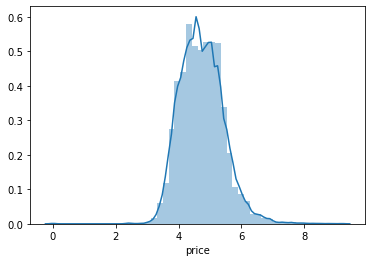

In [31]:

sns.distplot(np.log1p(airbnb.price))

<AxesSubplot:xlabel='price'>

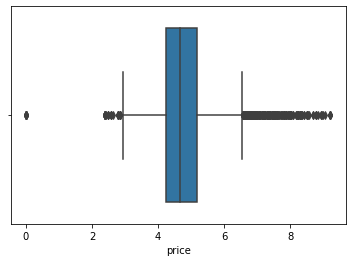

In [32]:
sns.boxplot(np.log1p(airbnb.price))

In [33]:
normalized_price = airbnb.loc[(np.log1p(airbnb.price)>=3) & (np.log1p(airbnb.price)<=6.5)]

In [34]:
print(airbnb.shape, normalized_price.shape)

(48895, 11) (48143, 11)


<AxesSubplot:xlabel='price'>

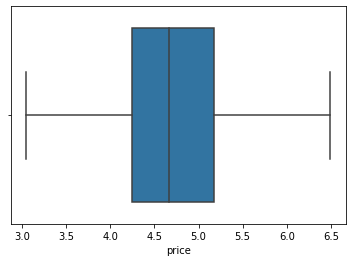

In [35]:
sns.boxplot(np.log1p(normalized_price.price))

## Data modeling

In [36]:
y = normalized_price.price              
X = normalized_price.drop(['price'], axis=1)

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
objc_type = [cnm for cnm in X_train.columns if X_train[cnm].nunique()<10 and X_train[cnm].dtype == 'object']
numeric_type = [cnm for cnm in X_train.columns if X_train[cnm].dtype == 'float64' or X_train[cnm].dtype == 'int64']
cls_training = objc_type + numeric_type

X_train2 = X_train[cls_training].copy()
X_valid2 = X_valid[cls_training].copy()

X_train2 = pd.get_dummies(X_train2)
X_valid2 = pd.get_dummies(X_valid2)

In [49]:
X_train2.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
5374,40.81419,-73.94717,4,27,0.46,1,196,0,0,1,0,0,0,1,0
37922,40.87064,-73.87970,1,9,1.19,2,310,1,0,0,0,0,0,1,0
18450,40.76328,-73.99280,60,28,0.82,1,343,0,0,1,0,0,1,0,0
2201,40.72346,-73.97907,5,35,0.46,1,320,0,0,1,0,0,0,1,0
14716,40.84326,-73.93901,14,1,0.03,2,0,0,0,1,0,0,1,0,0


In [53]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_train2, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid2, y_valid)], 
             verbose=False)


[17:15:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 68.0, RMSE: 220.223, MSE: 48498.103, MAPE: 0.442


In [56]:
predictions = my_model.predict(X_valid2)
print("MAE: " + str(np.round(mean_absolute_error(predictions, y_valid)))+
      ", RMSE: "+str(np.round(np.sqrt(mean_squared_error(predictions, y_valid)),3))+
      ", MSE: "+str(np.round((mean_squared_error(predictions, y_valid)),3))+
      ", MAPE: "+str(np.round(calculate_mape(y_valid, predictions),3)))

MAE: 68.0, RMSE: 220.223, MSE: 48498.103, MAPE: 0.442


## Model explainer 

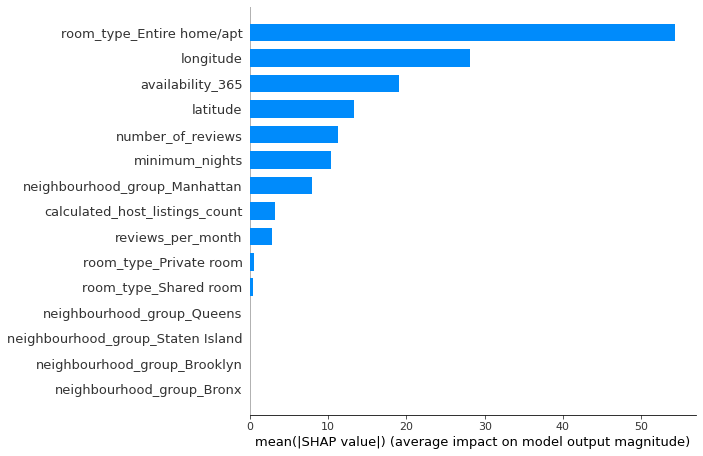

In [66]:
shap_values = shap.TreeExplainer(my_model).shap_values(X_train2)
shap.summary_plot(shap_values, X_train2, plot_type="bar")